# Notebook 2: CNF com Trace Exato

Este notebook implementa CNF completo com cálculo de log-likelihood via change of variables.

## Objetivos:
1. Implementar divergence_exact e CNF
2. Treinar em dados 2D e MNIST reduzido
3. Comparar com Real NVP baseline
4. Analisar escalabilidade


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import time
import torch
import torch.optim as optim
from src.models.cnf import CNF
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, MNISTReduced, get_dataloader
from src.utils.training import train_cnf, train_realnvp
from src.utils.visualization import (
    plot_data_distribution,
    plot_transformation,
    plot_transformation_realnvp,
    plot_vector_field,
    plot_vector_field_realnvp
)
from zuko.flows import RealNVP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directory for saving figures
FIGURES_DIR = '../results/figures'
os.makedirs(FIGURES_DIR, exist_ok=True)


Using device: cpu


## 1. Dataset 2D

Figure saved to: ../results/figures/02_data_distribution.png


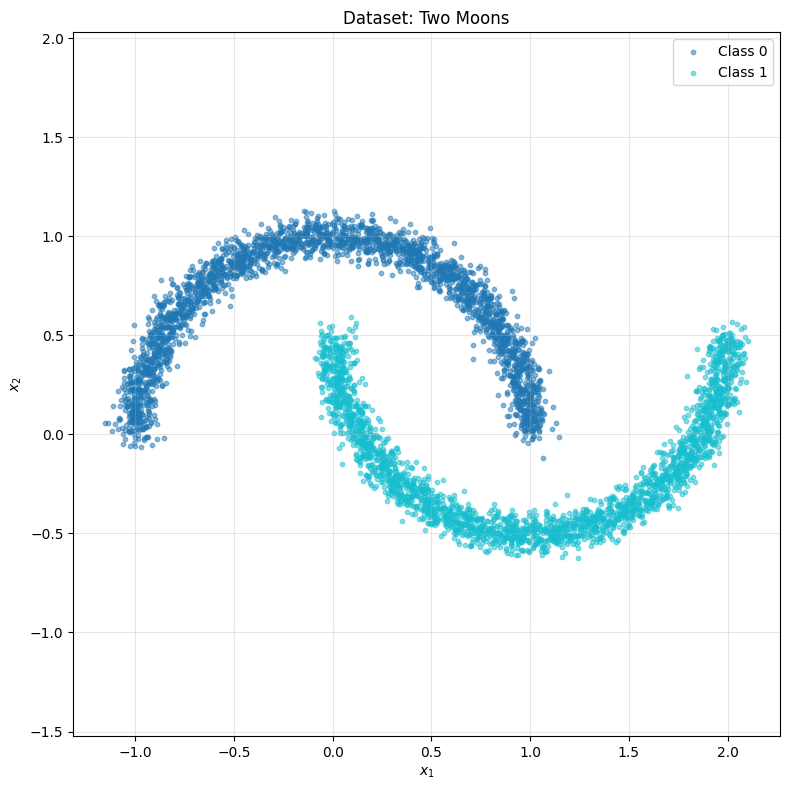

In [2]:
# Criar dataset 2D
dataset_2d = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader_2d = get_dataloader(dataset_2d, batch_size=128, shuffle=True)

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data_distribution(
    dataset_2d.data,
    labels=dataset_2d.labels,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, '02_data_distribution.png')
)
plt.tight_layout()
plt.show()


### 1.1 CNF


In [3]:
# Criar e treinar CNF
vf_2d = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d, rtol=1e-4, atol=1e-5)
optimizer_2d = optim.Adam(cnf_2d.parameters(), lr=1e-3)

print("Treinando CNF em dados 2D...")
train_cnf(cnf_2d, dataloader_2d, optimizer_2d, device, num_epochs=50)

# Avaliar log-likelihood
cnf_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    log_probs = cnf_2d.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")


Treinando CNF em dados 2D...


Epoch 1/50:  45%|████▌     | 18/40 [00:05<00:07,  3.13it/s]


KeyboardInterrupt: 

#### Visualization

In [ ]:
plot_transformation(
    cnf_2d,
    n_samples=1000,
    n_trajectory_points=100,
    save_path=os.path.join(FIGURES_DIR, '02_cnf_transformation.png')
)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    plot_vector_field(
        cnf_2d,
        xlim=(-2, 2),
        ylim=(-2, 2),
        n_grid=20,
        t=t,
        ax=axes[i]
    )
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_cnf_vector_fields.png'), dpi=300, bbox_inches='tight')
print(f"Figure saved to: {os.path.join(FIGURES_DIR, '02_cnf_vector_fields.png')}")
plt.show()

### 1.2. RealNVP


In [ ]:
# Criar e treinar RealNVP em dados 2D
realnvp_2d = RealNVP(
    features=2,
    transforms=4,
    hidden_features=[64, 64]
).to(device)

optimizer_rnvp_2d = optim.Adam(realnvp_2d.parameters(), lr=1e-3)

print("Treinando RealNVP em dados 2D...")
train_realnvp(
    realnvp_2d,
    dataloader_2d,
    optimizer_rnvp_2d,
    device,
    num_epochs=50
)

# Avaliar log-likelihood
realnvp_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    dist = realnvp_2d(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")


#### Visualization

In [ ]:
plot_transformation_realnvp(
    realnvp_2d,
    n_samples=1000,
    save_path=os.path.join(FIGURES_DIR, '02_realnvp_transformation.png')
)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    plot_vector_field_realnvp(
        realnvp_2d,
        xlim=(-2, 2),
        ylim=(-2, 2),
        n_grid=20,
        t=t,
        ax=axes[i]
    )
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_realnvp_vector_fields.png'), dpi=300, bbox_inches='tight')
print(f"Figure saved to: {os.path.join(FIGURES_DIR, '02_realnvp_vector_fields.png')}")
plt.show()


## 2. MNIST Reduzido

In [ ]:
# Criar dataset MNIST reduzido (100 dimensões)
print("Carregando MNIST reduzido...")
dataset_mnist = MNISTReduced(train=True, n_components=100)
dataloader_mnist = get_dataloader(dataset_mnist, batch_size=128, shuffle=True)

# Criar e treinar CNF
vf_mnist = VectorField(features=100, hidden_dims=[128, 128], time_embed_dim=32)
cnf_mnist = CNF(vf_mnist, atol=1e-5, rtol=1e-4).to(device)
optimizer_mnist = optim.Adam(cnf_mnist.parameters(), lr=1e-3)


### 2.1. CNF

In [ ]:

print("Treinando CNF em MNIST reduzido...")
start_time = time.time()
train_cnf(cnf_mnist, dataloader_mnist, optimizer_mnist, device, num_epochs=5)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
cnf_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    log_probs = cnf_mnist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = cnf_mnist.sample(1000)
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")


#### Visualization

In [ ]:
plot_transformation(
    cnf_mnist,
    pca=dataset_mnist.pca,
    n_samples=100
)
plt.tight_layout()
plt.show()


### 2.2. RealNVP

In [ ]:
# Criar e treinar RealNVP em MNIST reduzido
# RealNVP from zuko: 100 sample features, no context features
realnvp_mnist = RealNVP(
    features=100,
    transforms=4,
    hidden_features=[128, 128]
).to(device)

optimizer_rnvp_mnist = optim.Adam(realnvp_mnist.parameters(), lr=1e-3)

print("Treinando RealNVP em MNIST reduzido...")
start_time = time.time()
train_realnvp(realnvp_mnist, dataloader_mnist, optimizer_rnvp_mnist, device, num_epochs=5)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
realnvp_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    dist = realnvp_mnist(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = realnvp_mnist(None).sample((1000,))
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")

#### Visualization

In [ ]:
plot_transformation(
    realnvp_mnist,
    pca=dataset_mnist.pca,
    n_samples=100
)
plt.tight_layout()
plt.show()

## 5. Análise de Escalabilidade

**Por que trace exato não escala para MNIST completo (784 dim)?**

- Custo computacional: O(d²) onde d é a dimensão
- Para d=784: precisamos de 784 backward passes
- Cada backward é O(784) → Total O(784²) = O(614,656)
- Isso é muito lento para treinamento prático!

**Solução:** Usar Hutchinson trace estimator (FFJORD) - O(d)
